## Tutorial Notebook for Running EpiForecastStatMech

The goal of this notebook is to set up the basics for running EpiForecastStatMech The sections are:
  * Load Epi simulations or "real data" to train on
  * Set up model through Estimator framework. 
  * Train model


# Setup

Make sure you go Runtime->Change runtime time->TPU

In [ ]:
#@title Imports

! pip install --upgrade git+https://github.com/HopkinsIDD/EpiForecastStatMech.git
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import functools
from epi_forecast_stat_mech import data_model
from epi_forecast_stat_mech import high_level
import os
from epi_forecast_stat_mech.evaluation import run_on_data
from epi_forecast_stat_mech.evaluation import plot_predictions
from epi_forecast_stat_mech.evaluation import sim_metrics
from epi_forecast_stat_mech.mechanistic_models import mechanistic_models
from epi_forecast_stat_mech.statistical_models import linear_model
from epi_forecast_stat_mech.statistical_models import network_models
from epi_forecast_stat_mech.mechanistic_models import predict_lib

  Cloning https://github.com/HopkinsIDD/EpiForecastStatMech.git to /tmp/pip-req-build-ii_mskpt
  Running command git clone -q https://github.com/HopkinsIDD/EpiForecastStatMech.git /tmp/pip-req-build-ii_mskpt
     |████████████████████████████████| 467.9 MB 28 kB/s 
     |████████████████████████████████| 5.6 MB 35.3 MB/s 
     |████████████████████████████████| 183 kB 43.3 MB/s 
     |████████████████████████████████| 378 kB 43.2 MB/s 
     |████████████████████████████████| 118 kB 31.7 MB/s 
     |████████████████████████████████| 57 kB 4.0 MB/s 
     |████████████████████████████████| 12.8 MB 129 kB/s 
     |████████████████████████████████| 1.3 MB 12.0 MB/s 
     |████████████████████████████████| 2.3 MB 36.9 MB/s 
     |████████████████████████████████| 463 kB 35.1 MB/s 
     |████████████████████████████████| 5.7 MB 39.7 MB/s 
  Created wheel for EpiForecastStatMech: filename=EpiForecastStatMech-0.2-py3-none-any.whl size=104669 sha256=1bdd545db6c713e4a86d549b67140fb2e903c585a3931f

Make sure we're using a TPU, otherwise this is SLOW.


In [ ]:
if True: # To use this, make sure the Colab Runtime is set to Accelerator: TPU.
  import requests
  import os
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
  print(config.FLAGS.jax_backend_target)

grpc://10.82.221.170:8470


# Load Dataset

To start exploring the codebase, lets use a simulated dataset.  We've stored simulations in the [Google drive folder](https://drive.google.com/drive/folders/12SOGdLTSm5HfxlAAxF9R3I71TWvWLOzi?usp=sharing).

There are three simulations in the folder, two with social distancing. We will load the simulations without distancing as an illustrative case. 

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Load the dataset
# To see all datasets:
# !ls top_dir
top_dir = 'drive/MyDrive/JHU-epi-sprint/simulation_files_july13_2020/'
file_name = 'distancing_off.cdf'

In [ ]:
with open(top_dir+file_name, 'rb') as f:
    full_data = xr.load_dataset(f.read())

In [ ]:
full_data

<xarray.Dataset>
Dimensions:             (dynamic_covariate: 1, location: 100, mech_param: 3, static_covariate: 3, time: 100)
Coordinates:
  * static_covariate    (static_covariate) object 'one' 'two' 'population_size'
  * mech_param          (mech_param) object 'beta_0' 'beta_1' 'gamma'
Dimensions without coordinates: dynamic_covariate, location, time
Data variables:
    new_infections      (location, time) int32 1 0 0 1 1 2 ... 43 36 43 38 28 30
    static_covariates   (location, static_covariate) float32 -0.1482 ... 5.04...
    mech_params         (mech_param, location) float64 2.268 2.641 ... 0.07143
    dynamic_covariates  (dynamic_covariate, location, time) int32 0 0 0 ... 0 0
Attributes:
    write_time:  2020_07_08_17_05_06
    write_path:  /namespace/gas/primary/edklein/epi/2020_07_08/sir_social_dis...

## Tweak simulations

All of these simulations start at time 0, which is bad. We'll shift them to a random start time between 0 and 50. Note, there are fancier ways to do this shift, but this is nice because it's reproducible amongst the 3 datasets.

We'll also drop any locations that don't get at least 100 infections. When I generated these, the population sizes were between 10,000 and 1,000,000.

In [ ]:
minimum_num_infections = 100
num_locations = len(full_data.coords['location'])
num_time_steps = len(full_data.coords['time'])

In [ ]:
# Assign coordinates
# (you can ignore this for now, I forgot to do it before saving)
full_data = full_data.assign_coords({'time': np.arange(0,100), 'location': np.arange(0,100)})

In [ ]:
# Shift

np.random.seed(93)
location_shifts = xr.DataArray(np.random.randint(0,num_time_steps/2,size=num_locations), dims=['location',])
shifted_data = data_model.shift_timeseries_by(full_data, location_shifts)

In [ ]:
# Drop

data = shifted_data.where(shifted_data.new_infections.sum('time')>minimum_num_infections, drop=True)

## Look at data

All the data is stored in a dataset. The dataset has `data variables`. Each data variable is basically a giant array, but the dimensions have names. It also supports `sensible` indexing and slicing. 

In [ ]:
data

<xarray.Dataset>
Dimensions:             (dynamic_covariate: 1, location: 85, mech_param: 3, static_covariate: 3, time: 100)
Coordinates:
  * location            (location) int64 0 1 3 4 6 7 9 ... 92 93 95 96 97 98 99
  * static_covariate    (static_covariate) object 'one' 'two' 'population_size'
  * mech_param          (mech_param) object 'beta_0' 'beta_1' 'gamma'
  * time                (time) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: dynamic_covariate
Data variables:
    new_infections      (location, time) float64 0.0 0.0 ... 1.675e+03 1.405e+03
    static_covariates   (location, static_covariate) float32 -0.1482 ... 5.04...
    mech_params         (mech_param, location) float64 2.268 2.641 ... 0.07143
    dynamic_covariates  (location, dynamic_covariate, time) float64 0.0 ... 0.0
    start_time          (location) float64 37.0 27.0 24.0 15.0 ... 21.0 2.0 39.0
Attributes:
    write_time:  2020_07_08_17_05_06
    write_path:  /namespace/gas/primary/edklein/epi/2020_07_08/sir_social_dis...

The meat of the simulation is in the Data variable `new_infections`. We can access it either as 
```
full_data['new_infections`]
```
or as:



In [ ]:
data.new_infections

<xarray.DataArray 'new_infections' (location: 85, time: 100)>
array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 8.990e+02, 7.830e+02,
        6.720e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 8.040e+02, 6.870e+02,
        6.400e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.360e+02, 3.160e+02,
        2.880e+02],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 8.300e+01, 6.600e+01,
        4.900e+01],
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 1.700e+01, 1.400e+01,
        2.300e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.963e+03, 1.675e+03,
        1.405e+03]])
Coordinates:
  * location  (location) int64 0 1 3 4 6 7 9 10 11 ... 91 92 93 95 96 97 98 99
  * time      (time) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99

We can see that this infection data has two dimensions: time and location. Each location has 100 time steps. There are 85 locations (we dropped 15 due to the minimum number of infections threshold). We can access the coordinates of each dimension using `data.dim`, where dim is the dimension name. 

For a given location, we can plot the infection curve as a function of time.

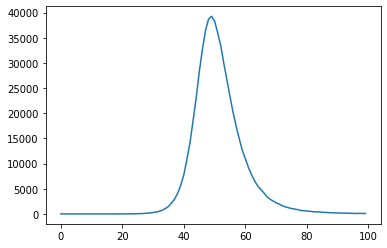

In [ ]:
loc_to_plot = 9
plt.plot(data.time, data.new_infections.isel(location=loc_to_plot))

Note that I can sensibly access the location using `isel(location=loc_to_plot)`. `isel` is short for integer select -- we select the 4th location we have data for.

Similarly, you can use `sel` to pick a specific location. This would make more sense if the locations had names such as `California`, etc. 

### Operations

We can also call functions directly on the arrays. For example, we can calculate the total number of infected individuals in each location.

In [ ]:
total_infected = data.new_infections.sum('time')
total_infected

<xarray.DataArray 'new_infections' (location: 85)>
array([204619., 940287., 951517., 948461., 110793., 741086., 733596.,
       194088.,  74016., 597934., 408435., 584160.,  36917., 866651.,
       476752.,  63611., 747424., 808022., 691151., 730373., 549041.,
       416444., 688931., 264335., 871099., 412673., 522952., 641058.,
       200609., 489760., 775317., 182369., 423759., 262274., 945513.,
       659197., 118845.,  36660., 981887.,  97857., 343927., 564441.,
       286025., 606550., 338552., 564978., 489954., 276026., 297371.,
       782524., 478369., 419619., 470387., 673378., 878832.,  72008.,
       921871.,  35610., 669168., 533456., 959154., 190044., 181453.,
       779946., 878902., 703464., 439856., 130582., 709722., 814004.,
       920817., 871937., 920701., 300632., 652539., 959332., 165411.,
       822804., 340270., 528035.,  47304., 131270., 140468., 201363.,
       490036.])
Coordinates:
  * location  (location) int64 0 1 3 4 6 7 9 10 11 ... 91 92 93 95 96 97 98 99

Note that the time dimension has disappeared! That's because we summed over time.

# Define mechanistic model

Here we define an SEIR-type mechanistic model. This is *just* the mechanistic model. We use it in an estimator in the next section.

In [ ]:
from epi_forecast_stat_mech.mechanistic_models.mechanistic_models import *

Note that the EpiStatMech codebase contains many different mechanistic models.   A list of the different models is here:

In [ ]:
list_of_mech_models=(
        mechanistic_models.ViboudChowellModel, mechanistic_models.GaussianModel,
        mechanistic_models.ViboudChowellModelPseudoLikelihood,
        mechanistic_models.GaussianModelPseudoLikelihood,
        mechanistic_models.StepBasedMultiplicativeGrowthModel,
        mechanistic_models.StepBasedSimpleMultiplicativeGrowthModel,
        mechanistic_models.StepBasedGeneralizedMultiplicativeGrowthModel,
        mechanistic_models.StepBasedBaselineSEIRModel,
        mechanistic_models.ViboudChowellModelPublished,
        mechanistic_models.TurnerModel)

In [ ]:
from epi_forecast_stat_mech.statistical_models import no_stat_model

Similarly, the codebase contains many different statistical models, a list of which is here:

In [ ]:
list_of_stat_module=(network_models.LinearModule,
                     network_models.NormalDistributionModel,
                         network_models.PlainLinearModule,
                         network_models.PerceptronModule, no_stat_model.Null),

It also contains other choices that are wrapped by the estimators. This includes:

Priors on parameters, time masks and preprocessing functions, and the choices of observables

In [ ]:
from epi_forecast_stat_mech import mask_time 
from epi_forecast_stat_mech.mechanistic_models import observables  
from epi_forecast_stat_mech.statistical_models import probability

In [ ]:
def seven_day_time_smooth_helper_(x):
  if "time" in x.dims and not np.issubdtype(x.dtype, np.datetime64):
    return x.rolling(time=7, min_periods=4).mean()
  else:
    return x


def seven_day_time_smooth(data):
  return xarray.Dataset({
      key: seven_day_time_smooth_helper_(x)
      for key, x in data.data_vars.items()
  })
def const_covariates(data):
  del data["static_covariates"]
  del data["static_covariate"]
  data["static_covariates"] = xarray.DataArray(
      np.zeros((data.sizes["location"], 1)),
      dims=["location", "static_covariate"])
  return data

In [ ]:
list_of_prior_fns=(probability.log_soft_mixed_laplace_on_kernels,)
list_of_time_mask_fn=(functools.partial(mask_time.make_mask, min_value=50),
                          functools.partial(
                              mask_time.make_mask,
                              min_value=1,
                              recent_day_limit=6 * 7),
                          functools.partial(
                              mask_time.make_mask,
                              min_value=1,
                              recent_day_limit=4 * 7))
list_of_preprocess_fn=(lambda x: x, seven_day_time_smooth,
                           const_covariates)
list_of_observable_choices=(observables.InternalParams(),),

# Estimator

 We'll use the StatMech estaimators as our base estimators.  These are the structures discussed in the paper.

Estimators take in a mechanistic model, a statistical model, and all other choices (masks/preprocessing, etc.) that are used to specify a model. The estimators have methods that are analogous to scikit learn, e.g. fit/predict, etc.

In the below we define a dictionary of different estimators.  The default for StatMechEstimator uses a VC mechanistic model, with an Normal-distribution statistical model.

Note that the last model in the dictionary contains more complexity and starts to expose why there are combinatorially many models -- and what the notation means for the model names!



In [ ]:
import sklearn.dummy
from epi_forecast_stat_mech import StatMechEstimator

def make_mean_estimators():
  return collections.defaultdict(
      lambda: sklearn.dummy.DummyRegressor(strategy='mean'))
  
def get_estimator_dict():
  train_steps=100000
  learning_rate=5e-4
  estimator_dict = {}
  estimator_dict['statmech_normal_SEIR'] = StatMechEstimator(
        train_steps=train_steps,
        mech_model=mechanistic_models.StepBasedBaselineSEIRModel(),
        learning_rate=learning_rate)
  estimator_dict['statmech_none_SEIR'] = StatMechEstimator(
        train_steps=train_steps,
        mech_model=mechanistic_models.StepBasedBaselineSEIRModel(),
        stat_model = no_stat_model.Null(),
        learning_rate=learning_rate)
  estimator_dict['statmech_normal_VC'] = StatMechEstimator(
        train_steps=train_steps,
        learning_rate=learning_rate)
  estimator_dict['statmech_mean_VC'] = StatMechEstimator(
        train_steps=train_steps,
        stat_model = make_mean_estimators(),
        learning_rate=learning_rate)
  estimator_dict['statmech_normal_multgrowth']=  StatMechEstimator(
        train_steps=train_steps,
        learning_rate=learning_rate,
        mech_model =  mechanistic_models.StepBasedMultiplicativeGrowthModel())
  estimator_dict['statmech_normal_turner'] = StatMechEstimator(
        train_steps=train_steps,
        learning_rate=learning_rate,
        mech_model=mechanistic_models.TurnerModel()),
  estimator_dict['statmech_normal_turner_more_stuff']=StatMechEstimator(
        train_steps=train_steps,
        learning_rate=learning_rate,
        stat_model = network_models.NormalDistributionModel(
          predict_module=network_models.LinearModule,
          log_prior_fn=probability.log_soft_mixed_laplace_on_kernels,
          scale_eps=1E-2,
          error_model="full"),
        mech_model=mechanistic_models.TurnerModel(),
        time_mask_fn=functools.partial(
                              mask_time.make_mask,
                              min_value=1,
                              recent_day_limit=4 * 7),
        #preprocess_fn=preprocess_fn,
        #observable_choice=observable_choice
        )

 
  return estimator_dict

# Fit

## Split data

Now we're ready to fit the estimator to our data! We first split the data into train and test sets. We want all of our training data to be *before* the social distancing turns *off*. Social distancing is determined by the dynamic_covariate.

We then split the data into train_data (before the last_sd_day) and ground truth/test data (after).

In [ ]:
train_data = data.copy(deep=True)
true_data = data.copy(deep=True)
split_day = 40
train_data['new_infections'] = data.new_infections.where(data.time<=split_day)
true_data['new_infections'] = data.new_infections.where(data.time>split_day)

## Set up estimator


All of our estimators are listed in get_estimator_dict above. We can look at all possible names:

In [ ]:
print(list(get_estimator_dict().keys()))

['statmech_normal_SEIR', 'statmech_none_SEIR', 'statmech_normal_VC', 'statmech_mean_VC', 'statmech_normal_multgrowth', 'statmech_normal_turner', 'statmech_normal_turner_more_stuff']


In [ ]:
# choose our estimator
estimator_key = 'statmech_normal_turner_more_stuff'
estimator = get_estimator_dict()[estimator_key]

## Train

In [ ]:
%time estimator.fit(train_data)

/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


Loss at step 0 is: 17068.25390625.
Loss at step 1000 is: 6036.8017578125.
Loss at step 2000 is: 4754.2119140625.
Loss at step 3000 is: 4356.021484375.
Loss at step 4000 is: 4205.07177734375.
Loss at step 5000 is: 4161.87109375.
Loss at step 6000 is: 4174.142578125.
Loss at step 7000 is: 4214.1728515625.
Loss at step 8000 is: 4264.00341796875.
Loss at step 9000 is: 4305.73828125.
Loss at step 10000 is: 4321.88818359375.
Loss at step 11000 is: 4295.7451171875.
Loss at step 12000 is: 4218.8515625.
Loss at step 13000 is: 4106.25830078125.
Loss at step 14000 is: 4025.313720703125.
Loss at step 15000 is: 4000.02734375.
Loss at step 16000 is: 3987.94384765625.
Loss at step 17000 is: 4063.4052734375.
Loss at step 18000 is: 4178.28466796875.
Loss at step 19000 is: 4113.24609375.
Loss at step 20000 is: 4107.71533203125.
Loss at step 21000 is: 4148.2978515625.
Loss at step 22000 is: 4092.084716796875.
Loss at step 23000 is: 4275.33740234375.
Loss at step 24000 is: 4177.35498046875.
Loss at step 2

/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


nan encountered. adjusted learning_rate: 0.000125


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


nan encountered. adjusted learning_rate: 6.25e-05


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


nan encountered. adjusted learning_rate: 3.125e-05


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


nan encountered. adjusted learning_rate: 1.5625e-05


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


Loss at step 26000 is: nan.
nan encountered. adjusted learning_rate: 7.8125e-06


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


nan encountered. adjusted learning_rate: 3.90625e-06


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


nan encountered. adjusted learning_rate: 1.953125e-06


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


Loss at step 27000 is: 4170.89794921875.
Loss at step 28000 is: 4170.572265625.
Loss at step 29000 is: 4170.51171875.
nan encountered. adjusted learning_rate: 9.765625e-07


/usr/local/lib/python3.7/dist-packages/flax/nn/base.py:273: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


Loss at step 30000 is: 4170.43212890625.
Loss at step 31000 is: 4170.384765625.
Loss at step 32000 is: 4220.4638671875.
Loss at step 33000 is: 4170.1982421875.
Loss at step 34000 is: 4171.4482421875.
Loss at step 35000 is: 4218.76123046875.
Loss at step 36000 is: 4220.42333984375.
Loss at step 37000 is: 4218.7822265625.
Loss at step 38000 is: 4171.26904296875.
Loss at step 39000 is: 4218.5751953125.
Loss at step 40000 is: 4169.9892578125.
Loss at step 41000 is: 4171.28369140625.
Loss at step 42000 is: 4219.888671875.
Loss at step 43000 is: 4170.00830078125.
Loss at step 44000 is: 4171.30712890625.
Loss at step 45000 is: 4219.7353515625.
Loss at step 46000 is: 4170.00537109375.
Loss at step 47000 is: 4220.06787109375.
Loss at step 48000 is: 4171.00341796875.
Loss at step 49000 is: 4171.015625.
Loss at step 50000 is: 4218.37255859375.
Loss at step 51000 is: 4170.91015625.
Loss at step 52000 is: 4170.9033203125.
Loss at step 53000 is: 4220.18115234375.
Loss at step 54000 is: 4170.91894531

StatMechEstimator(train_steps=100000, stat_model=NormalDistributionModel(predict_module=<class 'epi_forecast_stat_mech.statistical_models.network_models.LinearModule'>, log_prior_fn=<function log_soft_mixed_laplace_on_kernels at 0x7fdf38d1cd40>, error_model='full', scale_eps=0.01), mech_model=TurnerModel(new_infection_distribution=<class 'epi_forecast_stat_mech.mechanistic_models.mechanistic_models.FastPoisson'>), fused_train_steps=100, time_mask_fn=functools.partial(<function make_mask at 0x7fdf38dce440>, min_value=1, recent_day_limit=28), preprocess_fn=<function StatMechEstimator.<lambda> at 0x7fdf325ea680>, fit_seed=42, learning_rate=0.0005, observable_choice=<epi_forecast_stat_mech.mechanistic_models.observables.ObserveSpecified object at 0x7fdf0a66ce50>)

## Predictions

In [ ]:
num_samples = 100 # number of mc samples to roll out

In [ ]:
time_zero_predictions = estimator.predict(true_data, num_samples=num_samples)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:3176: UserW

These predicitons all start at time 100, we want to start them on the split day + 1. This way of shifting predictions puts `0`s up until the split day.

In [ ]:
predictions = data_model.shift_timeseries_by(xr.Dataset({'new_infections': time_zero_predictions}), (np.ones(85)*41).astype(int))
predictions = predictions.assign_coords({'time':np.arange(0,num_time_steps)})

# Eval


In [ ]:
# Add a model dimension to make the plotting code work
predictions = predictions.new_infections.expand_dims({'model':[estimator_key]})

This creates a new Dataset with all of our error metrics saved.

## Single Location Predictions

In [ ]:
# Hack to keep the figure and draw social distancing time
def plot_one_model_predictions(data_inf,
                               predictions,
                               model_to_plot,
                               location_to_plot,
                               plot_pred_function=plot_predictions.plot_rollout_samples,
                               plot_ground_truth=False,
                               ax=None):
  """Plot the data and predicted mean for a single model and location.

  Args:
    data_inf: an xr.DataArray representing the *true* new_infections with
      dimensions of (location, time).
    predictions: an xr.DataArray representing predicted new_infections with
      dimensions of (location, time, sample, model). Where model is the
       Estimator used to generate the predicted new_infections.
    model_to_plot: The coordinate name of the model that you want to plot.
    location_to_plot: The coordinate integer of the location that you want to
      plot.
    plot_pred_function: a function to plot the predicted mean values and some
      errors.
    plot_ground_truth: a boolean indicating whether to plot the ground truth
      new_infection values.
  Returns:
    None
  """

  if ax is None:
    plt.figure(figsize=(12, 8))
    legend = True
  else:
    plt.sca(ax)
    legend=False
  plot_pred_function(predictions, model_to_plot, location_to_plot)
  plot_predictions.plot_observed_data(data_inf, predictions, location_to_plot)
  if plot_ground_truth:
    plot_predictions.plot_ground_truth_data(data_inf, predictions, location_to_plot)
  plt.xlabel('Time')
  plt.ylabel('New infections')
  if legend:
    plt.legend()
  return None

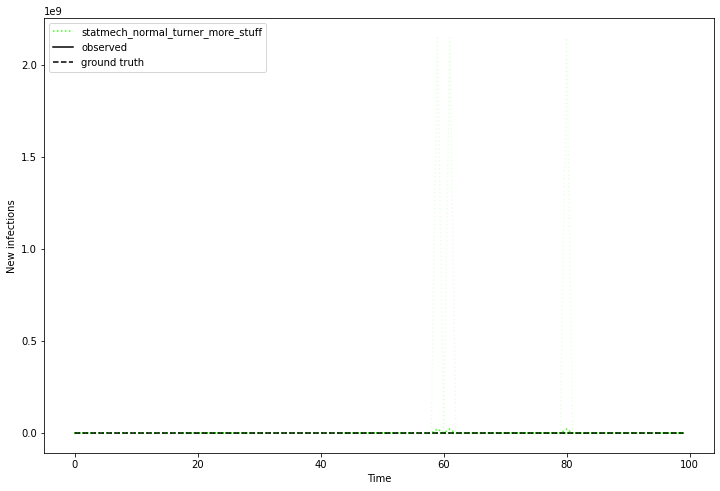

In [ ]:
# @title Single Location Predictions {run: "auto"}
# Currently can't set choices from a variable

location_to_plot = 29 #@param {type: "slider", min: 0, max: 100, step: 1}
# _ = plt.plot(data.time, data.dynamic_covariates.sel(location=location_to_plot, dynamic_covariate='distancing_status'))
plot_one_model_predictions(data.new_infections, predictions, estimator_key, location_to_plot, plot_ground_truth=True)
social_distancing_time = np.where(data.isel(location=location_to_plot).dynamic_covariates.squeeze(drop=True) > 0)[0]
if len(social_distancing_time):
  social_distancing_time = social_distancing_time.min()
  plt.axvline(social_distancing_time)

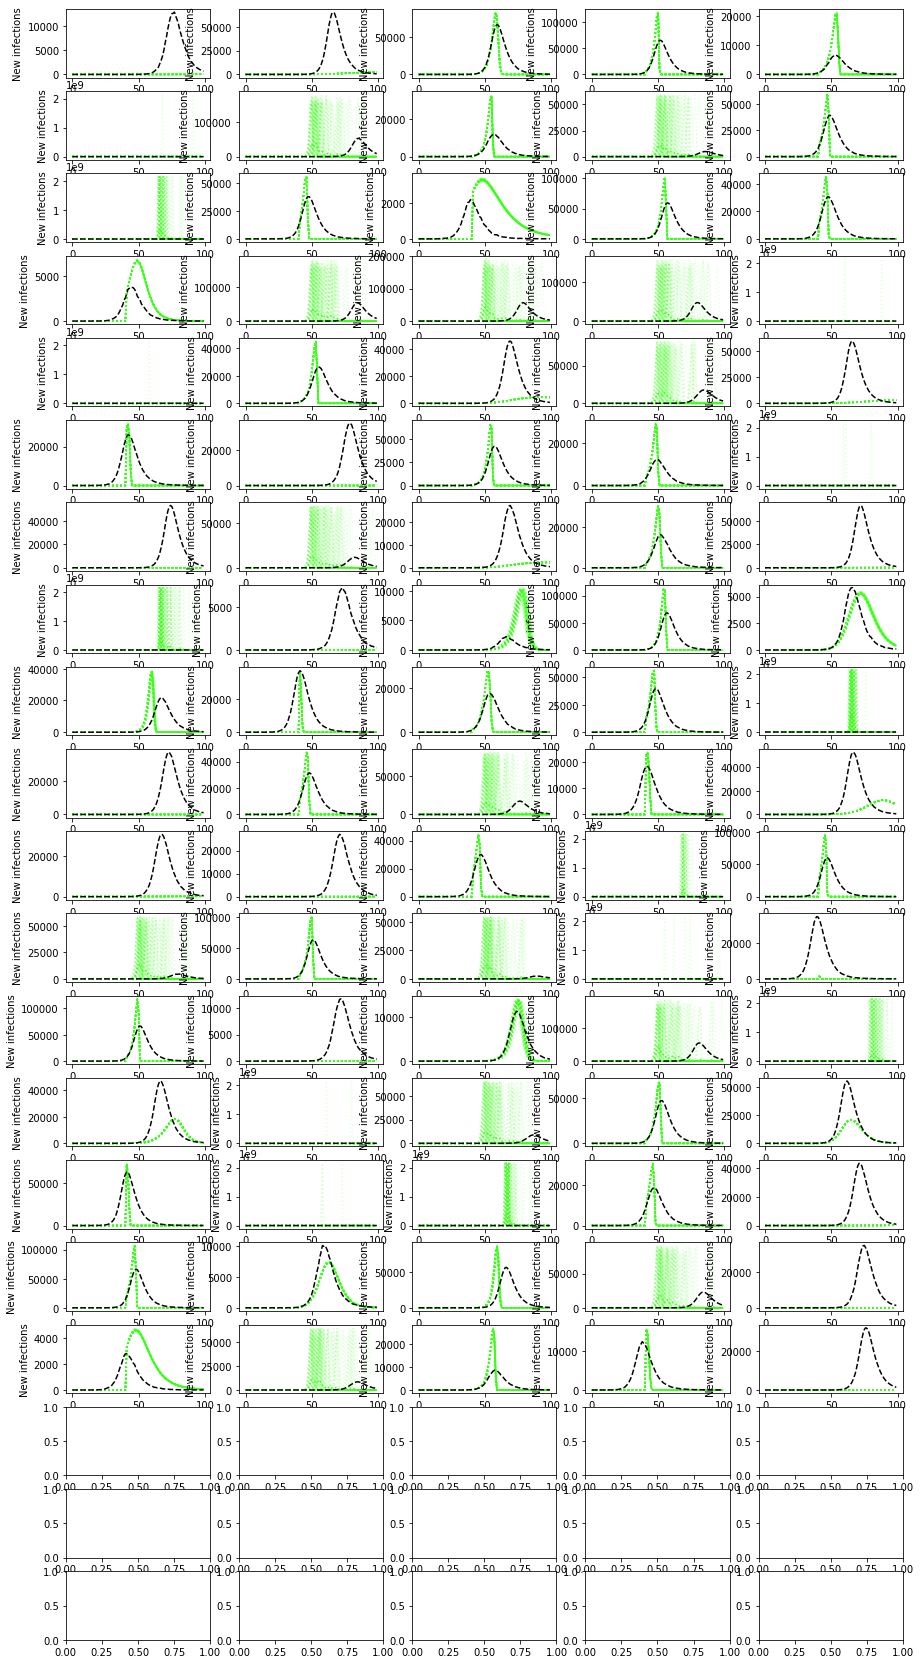

In [ ]:
fig, axarr = plt.subplots(20, 5, figsize=(15, 30))
for location_to_plot in range(len(data.coords['location'])):
  row = location_to_plot // 5
  col = location_to_plot % 5
  ax = axarr[row, col]
  plot_one_model_predictions(data.new_infections, predictions, estimator_key, location_to_plot, plot_ground_truth=True, ax=ax)
  social_distancing_time = np.where(data.isel(location=location_to_plot).dynamic_covariates.squeeze(drop=True) > 0)[0]
  if len(social_distancing_time):
    social_distancing_time = social_distancing_time.min()
    plt.axvline(social_distancing_time)

## Metrics

In [ ]:
error_dictionary = {}
for metric in list_of_metrics.keys():
  error_dictionary[metric] = list_of_metrics[metric](data.new_infections, predictions)

errors = xr.concat(
    list(error_dictionary.values()), dim=('metric'))
errors.coords['metric'] = list(error_dictionary.keys())

In [ ]:
list_of_metrics = {
    'time_25p_done': sim_metrics.time_percent_complete_error,
    'peak_time': sim_metrics.peak_time_error,
    'peak_size': sim_metrics.peak_size_error, 
    'two_weeks_out': sim_metrics.cumulative_inf_error,
    'total_size': sim_metrics.total_size_error,
}

In [ ]:
errors.coords

Coordinates:
  * model       (model) <U18 'statmech_normal_VC'
  * sample      (sample) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * location    (location) int64 0 1 3 4 6 7 9 10 11 ... 91 92 93 95 96 97 98 99
  * value_type  (value_type) <U12 'ground_truth' 'predicted' 'difference'
  * metric      (metric) <U13 'time_25p_done' 'peak_time' ... 'total_size'

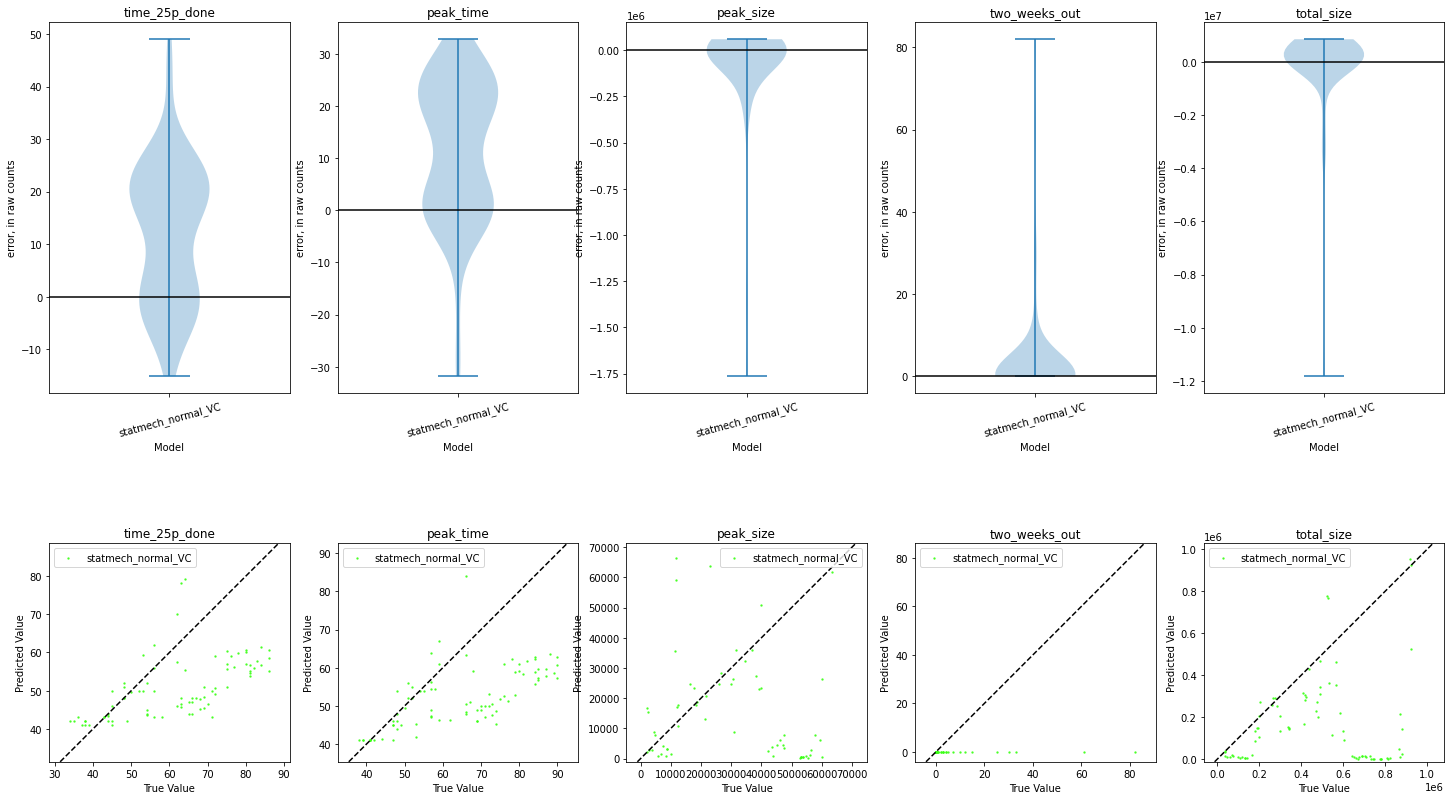

In [ ]:
models_to_plot = [estimator_key]
metrics_to_plot = errors.metric.values

plot_predictions.plot_violin_scatter(errors, models_to_plot, metrics_to_plot)

## Mechanistic Parameters

In [ ]:
mech_params = estimator.mech_params

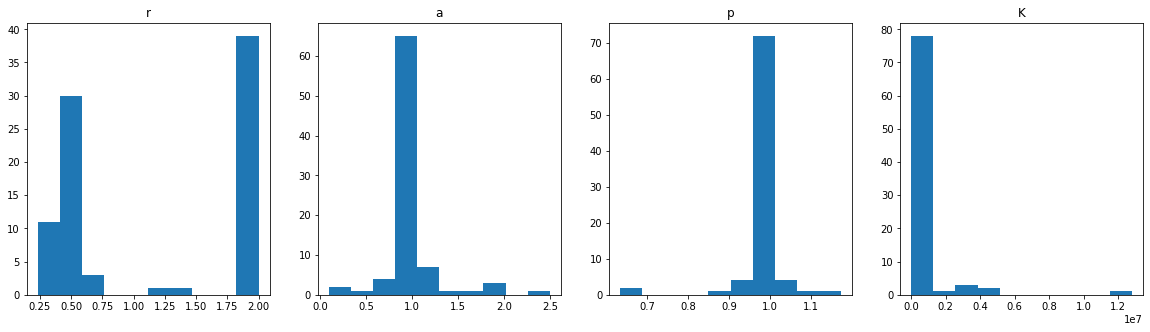

In [ ]:
num_params = len(mech_params.coords['param'])
fig, ax = plt.subplots(1,num_params, figsize=(5*num_params,5))
for i, p in enumerate(mech_params.coords['param'].data):
  ax[i].hist(mech_params.sel(param=p))
  ax[i].set_title(p)

We have the true final sizes, so let's compare those to K. \[this isn't expected to work out with dynamics like it is with static models.\]

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:739: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


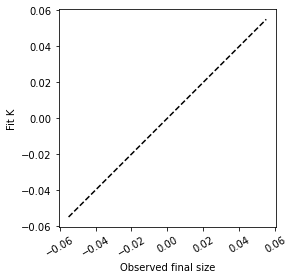

In [ ]:
log_k = mech_params.sel(param='K')
k = np.exp(log_k)

final_size = data.new_infections.sum('time')
plt.scatter(final_size, k);
ax = plt.gca()
ax.set_aspect('equal')
# plt.ylim(ax.get_xlim())
plt.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
plt.xlabel('Observed final size');
plt.xticks(rotation=30)
plt.ylabel('Fit K');

Let compare held out final size and average held out prediction final size. ("final" is just all data available after train)

In [ ]:
data

<xarray.Dataset>
Dimensions:             (dynamic_covariate: 1, location: 85, mech_param: 3, static_covariate: 3, time: 100)
Coordinates:
  * location            (location) int64 0 1 3 4 6 7 9 ... 92 93 95 96 97 98 99
  * static_covariate    (static_covariate) object 'one' 'two' 'population_size'
  * mech_param          (mech_param) object 'beta_0' 'beta_1' 'gamma'
  * time                (time) int64 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: dynamic_covariate
Data variables:
    new_infections      (location, time) float64 0.0 0.0 ... 1.675e+03 1.405e+03
    static_covariates   (location, static_covariate) float32 -0.1482 ... 5.04...
    mech_params         (mech_param, location) float64 2.268 2.641 ... 0.07143
    dynamic_covariates  (location, dynamic_covariate, time) float64 0.0 ... 0.0
    start_time          (location) float64 37.0 27.0 24.0 15.0 ... 21.0 2.0 39.0
Attributes:
    write_time:  2020_07_08_17_05_06
    write_path:  /namespace/gas/primary/edklein/epi/2020_07_08/sir_social_dis...

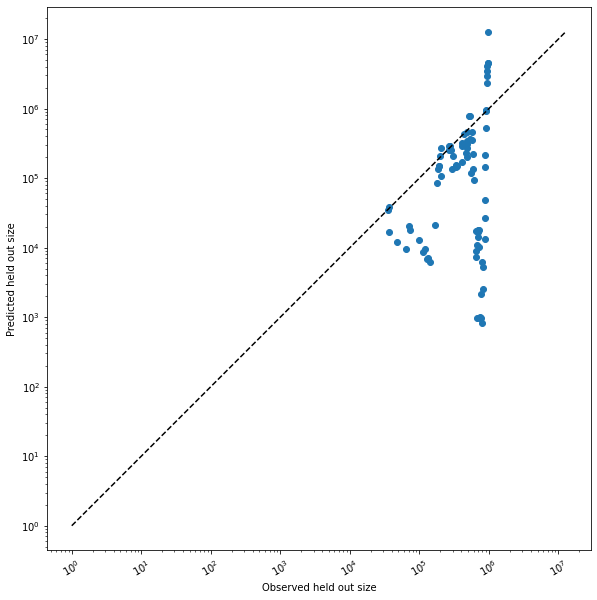

In [ ]:
predicted_final_size = predictions.mean('sample').sum('time').squeeze('model')
final_size = data.new_infections.where(data.time >= data.start_time).sum('time')
plt.figure(figsize=(12, 10))
plt.scatter(final_size, predicted_final_size);
xmax = np.max(np.concatenate((final_size, predicted_final_size)))
plt.xlim(1, xmax)
plt.ylim(1, xmax)
ax = plt.gca()
# ax.set_aspect('equal')
plt.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
plt.xlabel('Observed held out size')
plt.xticks(rotation=30)
plt.ylabel('Predicted held out size')
plt.xscale('log')
plt.yscale('log')
plt.axis('square') #equal bugs out.
pass


In [ ]:
# list(enumerate(zip(final_size.data, (predicted_final_size).astype(np.int32).data)))

Let compare observed final size and average prediction final size. ("final" is just all data available)

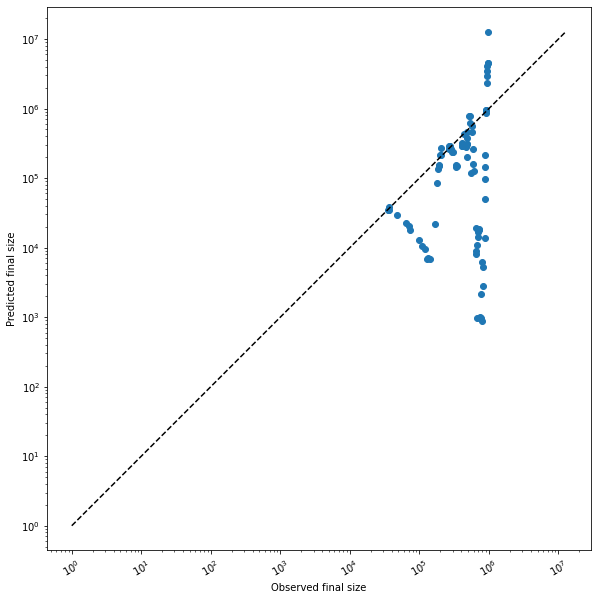

In [ ]:
# predicted_final_size = sim_metrics._helper_construct_dataarray(train_data.new_infections, predictions).squeeze('model').sel(value_type='predicted').mean('sample').sum('time')
predicted_final_size = xr.concat([train_data.new_infections, predictions.squeeze('model').mean('sample')], 'time').sum('time')
final_size = data.new_infections.sum('time')
plt.figure(figsize=(12, 10))
plt.scatter(final_size, predicted_final_size);
xmax = np.max(np.concatenate((final_size, predicted_final_size)))
plt.xlim(1, xmax)
plt.ylim(1, xmax)
ax = plt.gca()
# ax.set_aspect('equal')
plt.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
plt.xlabel('Observed final size')
plt.xticks(rotation=30)
plt.ylabel('Predicted final size')
plt.xscale('log')
plt.yscale('log')
plt.axis('square') #equal bugs out.
pass
